<a href="https://colab.research.google.com/github/deovrat-n/stock-price-prediction-II/blob/main/Live_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#yahoo finance as data source

import yfinance as yf

In [51]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'ASIANPAINT.NS'

In [52]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [53]:
type(data)

pandas.core.frame.DataFrame

In [54]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-08-14,1149.449951,1163.699951,1145.0,1154.000000,1114.454834,511994
2017-08-16,1154.349976,1155.300049,1129.0,1141.300049,1102.190308,857454
2017-08-17,1141.300049,1142.800049,1132.0,1134.949951,1096.057739,494638
2017-08-18,1131.949951,1142.449951,1123.0,1140.000000,1100.934814,357491
2017-08-21,1141.800049,1141.800049,1128.5,1134.449951,1095.574951,456594


In [55]:
len(data)

1236

In [56]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-05,3475.0,3491.949951,3451.550049,3473.899902,3473.899902,792478
2022-08-08,3465.0,3476.949951,3436.550049,3458.449951,3458.449951,724644
2022-08-10,3441.0,3449.850098,3396.000000,3411.649902,3411.649902,1089295
2022-08-11,3450.0,3477.949951,3390.000000,3405.199951,3405.199951,1410533
2022-08-12,3399.0,3434.800049,3383.000000,3427.850098,3427.850098,548472


In [57]:
opn = data[['Open']]

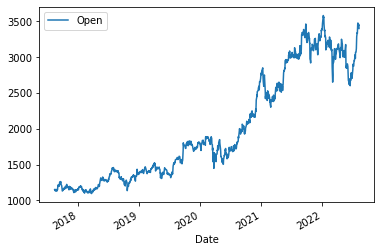

In [58]:
opn.plot()

In [59]:
import matplotlib.pyplot as plt

In [60]:
ds = opn.values

In [61]:
ds

array([[1149.44995117],
       [1154.34997559],
       [1141.30004883],
       ...,
       [3441.        ],
       [3450.        ],
       [3399.        ]])

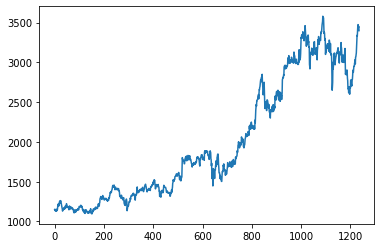

In [62]:
plt.plot(ds)

In [63]:
import numpy as np

In [64]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [66]:
len(ds_scaled), len(ds)

(1236, 1236)

In [67]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [68]:
train_size,test_size

(865, 371)

In [69]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [70]:
len(ds_train),len(ds_test)

(865, 371)

In [71]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [86]:
#Taking 100 days price as one record for training
time_stamp = 50
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [87]:
X_train.shape,y_train.shape

((814, 50), (814,))

In [88]:
X_test.shape, y_test.shape

((320, 50), (320,))

In [89]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [90]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [91]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [101]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64)

Epoch 1/50
13/13 [==============================] - 10s 217ms/step - loss: 7.9990e-04 - val_loss: 8.7813e-04
Epoch 2/50
13/13 [==============================] - 1s 115ms/step - loss: 3.4090e-04 - val_loss: 8.9814e-04
Epoch 3/50
13/13 [==============================] - 1s 115ms/step - loss: 2.8352e-04 - val_loss: 0.0036
Epoch 4/50
13/13 [==============================] - 1s 110ms/step - loss: 2.6571e-04 - val_loss: 0.0024
Epoch 5/50
13/13 [==============================] - 1s 115ms/step - loss: 2.3934e-04 - val_loss: 0.0013
Epoch 6/50
13/13 [==============================] - 1s 111ms/step - loss: 2.3968e-04 - val_loss: 0.0019
Epoch 7/50
13/13 [==============================] - 1s 114ms/step - loss: 2.3644e-04 - val_loss: 0.0010
Epoch 8/50
13/13 [==============================] - 1s 111ms/step - loss: 2.4187e-04 - val_loss: 0.0010
Epoch 9/50
13/13 [==============================] - 1s 112ms/step - loss: 2.2340e-04 - val_loss: 0.0018
Epoch 10/50
13/13 [==============================] - 1s

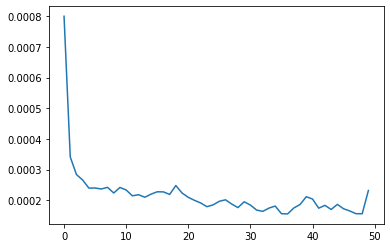

In [102]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [103]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [104]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

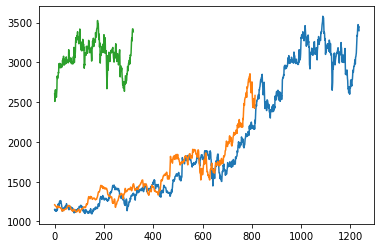

In [105]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [106]:
type(train_predict)

numpy.ndarray

In [107]:
test = np.vstack((train_predict,test_predict))

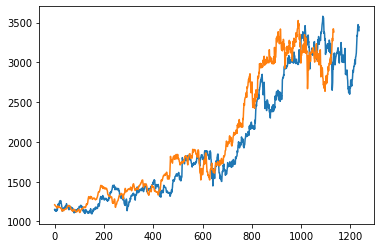

In [108]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)